In [ ]:
Title- Sentimental analysis using twitter dataset in apache pyspark

VISHNU SHASHANK    (20MCB1009)
EZHIL OVIYA.D      (20MCB1003)
AKSHAY KUMAR YADAV (20MCB1015)

In [ ]:
!apt-get update
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:12 http://security.ubuntu.com/ub

In [ ]:
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

!pip install langid
import langid

from pyspark.sql.types import StringType,FloatType,StructType,StructField

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords

from nltk import RegexpParser
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

!pip install regex
import re 
import string




     |████████████████████████████████| 1.9MB 5.5MB/s 
  Created wheel for langid: filename=langid-1.1.6-cp36-none-any.whl size=1941192 sha256=7dbb0518867895dc0ec2754799cfdd26b0106ad621bad0f31897af798d3000d3
  Stored in directory: /root/.cache/pip/wheels/29/bc/61/50a93be85d1afe9436c3dc61f38da8ad7b637a38af4824e86e
Successfully built langid
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(sc)

In [ ]:
def check_blanks(data_str):
    is_blank = str(data_str.isspace())
    return is_blank

In [ ]:
def check_lang(data_str):
    predict_lang = langid.classify(data_str)
    if predict_lang[1] >= .9:
        language = predict_lang[0]
    else:
        language = 'NA'
    return language

In [ ]:

def remove_features(data_str):
    # compile regex
    url_re = re.compile('https?://(www.)?\w+\.\w+(/\w+)*/?')
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    num_re = re.compile('(\\d+)')
    mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
    # convert to lowercase
    data_str = data_str.lower()
    # remove hyperlinks
    data_str = url_re.sub(' ', data_str)
    # remove @mentions
    data_str = mention_re.sub(' ', data_str)
    # remove puncuation
    data_str = punc_re.sub(' ', data_str)
    # remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
    # remove non a-z 0-9 characters and words shorter than 3 characters
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word) and len(word) > 2:
                cleaned_str = word
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word) and len(word) > 2:
                cleaned_str = cleaned_str + ' ' + word
            else:
                cleaned_str += ' '
        list_pos += 1
    return cleaned_str

In [ ]:
def remove_stops(data_str):
    stops = set(stopwords.words("english"))
    list_pos = 0
    cleaned_str = ''
    text = data_str.split()
    for word in text:
        if word not in stops:
            if list_pos == 0:
                cleaned_str = word
            else:
                cleaned_str = cleaned_str + ' ' + word
            list_pos += 1
    return cleaned_str

In [ ]:
def tag_and_remove(data_str):
    cleaned_str = ' '
    # noun tags
    nn_tags = ['NN', 'NNP', 'NNP', 'NNPS', 'NNS']
    # adjectives
    jj_tags = ['JJ', 'JJR', 'JJS']
    # verbs
    vb_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    nltk_tags = nn_tags + jj_tags + vb_tags

    text = data_str.split()

    # tagging the text and keep only those which have right tags
    tagged_text = pos_tag(text)
    for tagged_word in tagged_text:
        if tagged_word[1] in nltk_tags:
            cleaned_str += tagged_word[0] + ' '

    return cleaned_str

In [ ]:
def lemmatize(data_str):
    list_pos = 0
    cleaned_str = ''
    lmtzr = WordNetLemmatizer()
    text = data_str.split()
    tagged_words = pos_tag(text)
    for word in tagged_words:
        if 'v' in word[1].lower():
            lemma = lmtzr.lemmatize(word[0], pos='v')
        else:
            lemma = lmtzr.lemmatize(word[0], pos='n')
        if list_pos == 0:
            cleaned_str = lemma
        else:
            cleaned_str = cleaned_str + ' ' + lemma
        list_pos += 1
    return cleaned_str

In [ ]:
check_lang_udf = udf(check_lang, StringType())
remove_stops_udf = udf(remove_stops, StringType())
remove_features_udf = udf(remove_features, StringType())
tag_and_remove_udf = udf(tag_and_remove, StringType())
lemmatize_udf = udf(lemmatize, StringType())
check_blanks_udf = udf(check_blanks, StringType())

In [ ]:
final_schema = StructType([StructField("text", StringType(),True),
                           StructField("id",StringType(),True),
                           StructField("label",FloatType(), True)])


In [ ]:
data_df=spark.read.schema(final_schema).csv('/content/twitter1.csv')

In [ ]:
data_df.show(5)

+--------------------+----------+-----+
|                text|        id|label|
+--------------------+----------+-----+
|@switchfoot http:...|1467810369|  0.0|
|is upset that he ...|1467810672|  0.0|
|@Kenichan I dived...|1467810917|  0.0|
|my whole body fee...|1467811184|  0.0|
|@nationwideclass ...|1467811193|  0.0|
+--------------------+----------+-----+
only showing top 5 rows



In [ ]:
data_df.printSchema()

root
 |-- text: string (nullable = true)
 |-- id: string (nullable = true)
 |-- label: float (nullable = true)



In [ ]:
# get the raw columns
raw_cols = data_df.columns
print(raw_cols)

['text', 'id', 'label']


In [ ]:
lang_df = data_df.withColumn("lang", check_lang_udf(data_df["text"]))
en_df = lang_df.filter(lang_df["lang"] == "en")
en_df.show(4)w

+--------------------+----------+-----+----+
|                text|        id|label|lang|
+--------------------+----------+-----+----+
|No picnic  my pho...|1467833672|  0.0|  en|
|watching &quot;Ho...|1467837470|  0.0|  en|
|      almost bedtime|1467842299|  0.0|  en|
|       Agh...snow!!!|1467842448|  0.0|  en|
+--------------------+----------+-----+----+
only showing top 4 rows



In [ ]:
rm_stops_df = en_df.select(raw_cols)\
                   .withColumn("stop_text", remove_stops_udf(en_df["text"]))
rm_stops_df.show(4)

+--------------------+----------+-----+--------------------+
|                text|        id|label|           stop_text|
+--------------------+----------+-----+--------------------+
|No picnic  my pho...|1467833672|  0.0|No picnic phone s...|
|watching &quot;Ho...|1467837470|  0.0|watching &quot;Ho...|
|      almost bedtime|1467842299|  0.0|      almost bedtime|
|       Agh...snow!!!|1467842448|  0.0|       Agh...snow!!!|
+--------------------+----------+-----+--------------------+
only showing top 4 rows



In [ ]:
rm_features_df = rm_stops_df.select(raw_cols+["stop_text"])\
                            .withColumn("feat_text", \
                            remove_features_udf(rm_stops_df["stop_text"]))
rm_features_df.show(4)

+--------------------+----------+-----+--------------------+--------------------+
|                text|        id|label|           stop_text|           feat_text|
+--------------------+----------+-----+--------------------+--------------------+
|No picnic  my pho...|1467833672|  0.0|No picnic phone s...|  picnic phone sm...|
|watching &quot;Ho...|1467837470|  0.0|watching &quot;Ho...|watching quot hou...|
|      almost bedtime|1467842299|  0.0|      almost bedtime|      almost bedtime|
|       Agh...snow!!!|1467842448|  0.0|       Agh...snow!!!|            agh snow|
+--------------------+----------+-----+--------------------+--------------------+
only showing top 4 rows



In [ ]:
tagged_df = rm_features_df.select(raw_cols+["feat_text"]) \
                          .withColumn("tagged_text", \
                           tag_and_remove_udf(rm_features_df.feat_text))

tagged_df.show(4)

+--------------------+----------+-----+--------------------+--------------------+
|                text|        id|label|           feat_text|         tagged_text|
+--------------------+----------+-----+--------------------+--------------------+
|No picnic  my pho...|1467833672|  0.0|  picnic phone sm...| picnic phone sme...|
|watching &quot;Ho...|1467837470|  0.0|watching quot hou...| watching quot ho...|
|      almost bedtime|1467842299|  0.0|      almost bedtime|            bedtime |
|       Agh...snow!!!|1467842448|  0.0|            agh snow|           agh snow |
+--------------------+----------+-----+--------------------+--------------------+
only showing top 4 rows



In [ ]:
lemm_df = tagged_df.select(raw_cols+["tagged_text"]) \
                   .withColumn("lemm_text", lemmatize_udf(tagged_df["tagged_text"]))
lemm_df.show(4)

+--------------------+----------+-----+--------------------+--------------------+
|                text|        id|label|         tagged_text|           lemm_text|
+--------------------+----------+-----+--------------------+--------------------+
|No picnic  my pho...|1467833672|  0.0| picnic phone sme...|picnic phone smel...|
|watching &quot;Ho...|1467837470|  0.0| watching quot ho...|watch quot house ...|
|      almost bedtime|1467842299|  0.0|            bedtime |             bedtime|
|       Agh...snow!!!|1467842448|  0.0|           agh snow |            agh snow|
+--------------------+----------+-----+--------------------+--------------------+
only showing top 4 rows



In [ ]:
check_blanks_df = lemm_df.select(raw_cols+["lemm_text"])\
                             .withColumn("is_blank", check_blanks_udf(lemm_df["lemm_text"]))
    # remove blanks
no_blanks_df = check_blanks_df.filter(check_blanks_df["is_blank"] == "False")

# drop duplicates
dedup_df = no_blanks_df.dropDuplicates(['text', 'label'])

dedup_df.show(4)

+--------------------+----------+-----+---------+--------+
|                text|        id|label|lemm_text|is_blank|
+--------------------+----------+-----+---------+--------+
|@CoderNeedsFood ugh.|1752740530|  0.0|         |   False|
|@Marievh  http://...|1834156755|  1.0|         |   False|
|@RussFilice Now I...|1833636946|  1.0|     love|   False|
|@SRBMALIK  Clean Me!|1564143990|  0.0|    clean|   False|
+--------------------+----------+-----+---------+--------+
only showing top 4 rows



In [ ]:
from pyspark.sql.functions import monotonically_increasing_id
# Create Unique ID
lemm_df = lemm_df.withColumn("uid", monotonically_increasing_id())
lemm_df.show(4)

+--------------------+----------+-----+--------------------+--------------------+---+
|                text|        id|label|         tagged_text|           lemm_text|uid|
+--------------------+----------+-----+--------------------+--------------------+---+
|No picnic  my pho...|1467833672|  0.0| picnic phone sme...|picnic phone smel...|  0|
|watching &quot;Ho...|1467837470|  0.0| watching quot ho...|watch quot house ...|  1|
|      almost bedtime|1467842299|  0.0|            bedtime |             bedtime|  2|
|       Agh...snow!!!|1467842448|  0.0|           agh snow |            agh snow|  3|
+--------------------+----------+-----+--------------------+--------------------+---+
only showing top 4 rows



In [ ]:
data = lemm_df.select('uid','lemm_text','label')
data.show(4)

+---+--------------------+-----+
|uid|           lemm_text|label|
+---+--------------------+-----+
|  0|picnic phone smel...|  0.0|
|  1|watch quot house ...|  0.0|
|  2|             bedtime|  0.0|
|  3|            agh snow|  0.0|
+---+--------------------+-----+
only showing top 4 rows



In [ ]:

(trainingData, testData) = data.randomSplit([0.8, 0.2])

In [ ]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes

tokenizer = Tokenizer(inputCol="lemm_text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="rawFeatures")
idf = IDF(minDocFreq=3, inputCol="rawFeatures", outputCol="features")

nb = NaiveBayes()

pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, nb])

model = pipeline.fit(trainingData)

In [ ]:
predictions = model.transform(testData)

predictions.select("lemm_text", "label", "prediction").show(5,False) 

+---------------------+-----+----------+
|lemm_text            |label|prediction|
+---------------------+-----+----------+
|watch quot house quot|0.0  |1.0       |
|reckon               |0.0  |1.0       |
|work                 |0.0  |0.0       |
|new post             |0.0  |1.0       |
|tire                 |0.0  |0.0       |
+---------------------+-----+----------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
evaluator.evaluate(predictions)


0.8089727234068405

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.8132560570201448

In [ ]:
model.save           

<bound method MLWritable.save of PipelineModel_6c0b20682d1b>

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')

In [ ]:
data = sc.textFile('/content/dataset.txt')
df_loads = spark.read.option("header", "true").csv(data)
print(" spark dataframe sample:")
df_loads.show(5, False)



 spark dataframe sample:
+-------------------------------------------------------------------------------------------------------------------+
|lemm_text                                                                                                          |
+-------------------------------------------------------------------------------------------------------------------+
|@BerzerkerBuilds Why does #Trump think that #Biden2020 would repeat a #Trump campaign slogan????                   |
|RT @kenklippenstein: Yesterday as Trump refused to condemn far-right violence                                      |
|RT @ddale8: Almost every single thing Trump said in the debate segment on mail-in voting was wrong.                |
|With @MarshallCohen                                                                                                |
|RT @paulsperry_: Pundits &amp; Never-Trumpers still don't get why Trump's base remains so loyal to him. Here's why:|
+------------------------------

In [ ]:
df_loads = df_loads.withColumn('lemm_text', regexp_replace('lemm_text','RT', ''))
df_loads.show(5,False)

+-----------------------------------------------------------------------------------------------------------------+
|lemm_text                                                                                                        |
+-----------------------------------------------------------------------------------------------------------------+
|@BerzerkerBuilds Why does #Trump think that #Biden2020 would repeat a #Trump campaign slogan????                 |
| @kenklippenstein: Yesterday as Trump refused to condemn far-right violence                                      |
| @ddale8: Almost every single thing Trump said in the debate segment on mail-in voting was wrong.                |
|With @MarshallCohen                                                                                              |
| @paulsperry_: Pundits &amp; Never-Trumpers still don't get why Trump's base remains so loyal to him. Here's why:|
+-----------------------------------------------------------------------

In [ ]:
df_loads = df_loads.withColumn('lemm_text', regexp_replace('lemm_text','@\w+', ''))
df_loads.show(5,False)

+-----------------------------------------------------------------------------------------------------+
|lemm_text                                                                                            |
+-----------------------------------------------------------------------------------------------------+
| Why does #Trump think that #Biden2020 would repeat a #Trump campaign slogan????                     |
| : Yesterday as Trump refused to condemn far-right violence                                          |
| : Almost every single thing Trump said in the debate segment on mail-in voting was wrong.           |
|With                                                                                                 |
| : Pundits &amp; Never-Trumpers still don't get why Trump's base remains so loyal to him. Here's why:|
+-----------------------------------------------------------------------------------------------------+
only showing top 5 rows



In [ ]:
df_loads = df_loads.withColumn('lemm_text', regexp_replace('lemm_text','http\S+', ''))

In [ ]:
df_loads = df_loads.withColumn('lemm_text', regexp_replace('lemm_text','www.[^ ]+', ''))

In [ ]:
df_loads = df_loads.withColumn('lemm_text', regexp_replace('lemm_text','[0-9]+',''))

In [ ]:
df_loads = df_loads.withColumn('lemm_text', regexp_replace('lemm_text','[!"#$%&()*+,-./:;<=>?@^_`{|}~]',''))

In [ ]:
df_loads = df_loads.withColumn('lemm_text', regexp_replace('lemm_text','trump',''))

In [ ]:
df_loads = df_loads.withColumn('lemm_text', regexp_replace('lemm_text','biden',''))

In [ ]:
df_loads.show(5,False)

+-----------------------------------------------------------------------------------------------+
|lemm_text                                                                                      |
+-----------------------------------------------------------------------------------------------+
| Why does Trump think that Biden would repeat a Trump campaign slogan                          |
|  Yesterday as Trump refused to condemn farright violence                                      |
|  Almost every single thing Trump said in the debate segment on mailin voting was wrong        |
|With                                                                                           |
|  Pundits amp NeverTrumpers still don't get why Trump's base remains so loyal to him Here's why|
+-----------------------------------------------------------------------------------------------+
only showing top 5 rows



In [ ]:
predictions = model.transform(df_loads)

# Select example rows to display.
predictions.select("lemm_text","prediction").show(5,False) 

+-----------------------------------------------------------------------------------------------+----------+
|lemm_text                                                                                      |prediction|
+-----------------------------------------------------------------------------------------------+----------+
| Why does Trump think that Biden would repeat a Trump campaign slogan                          |0.0       |
|  Yesterday as Trump refused to condemn farright violence                                      |0.0       |
|  Almost every single thing Trump said in the debate segment on mailin voting was wrong        |1.0       |
|With                                                                                           |1.0       |
|  Pundits amp NeverTrumpers still don't get why Trump's base remains so loyal to him Here's why|1.0       |
+-----------------------------------------------------------------------------------------------+----------+
only showing top 5 

In [ ]:
data007=predictions.select("lemm_text","prediction")

In [ ]:
data007.columns

['lemm_text', 'prediction']

In [ ]:
data007.select('prediction').show()

+----------+
|prediction|
+----------+
|       0.0|
|       0.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       0.0|
|       1.0|
|       0.0|
+----------+
only showing top 20 rows



In [ ]:
data007.printSchema()

root
 |-- lemm_text: string (nullable = true)
 |-- prediction: double (nullable = false)



In [ ]:
df_neg=data007.filter(data007.prediction==0)
df_neg.show(5)

+--------------------+----------+
|           lemm_text|prediction|
+--------------------+----------+
| Why does Trump t...|       0.0|
|  Yesterday as Tr...|       0.0|
|Time to clean house |       0.0|
|  Trump Battered ...|       0.0|
|  I rewatched the...|       0.0|
+--------------------+----------+
only showing top 5 rows



In [ ]:
df_pos=data007.filter(data007.prediction==1)
df_pos.show(5)

+--------------------+----------+
|           lemm_text|prediction|
+--------------------+----------+
|  Almost every si...|       1.0|
|               With |       1.0|
|  Pundits amp Nev...|       1.0|
| Trump's endeavor...|       1.0|
|  Since President...|       1.0|
+--------------------+----------+
only showing top 5 rows



In [ ]:
df_pos_count=df_pos.select(count('prediction'))
df_pos_count.show(5)

+-----------------+
|count(prediction)|
+-----------------+
|            19841|
+-----------------+



In [ ]:
df_neg_count=df_neg.select(count('prediction'))
df_neg_count.show()

+-----------------+
|count(prediction)|
+-----------------+
|             5819|
+-----------------+



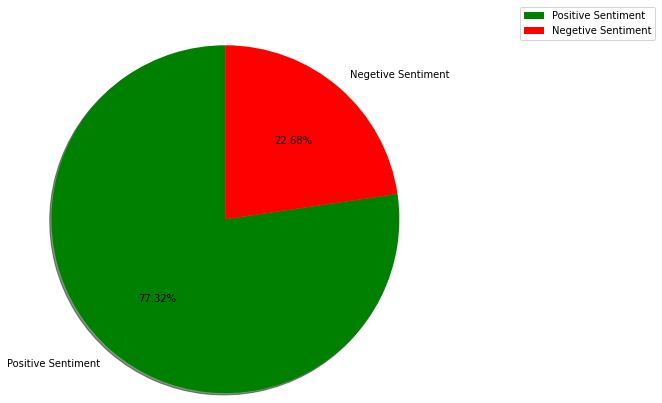

In [ ]:
    sentiments = ['Positive Sentiment', 'Negetive Sentiment'] 
    slices = [19841, 5819] 
    colors = ['g', 'r'] 
    plt.pie(slices, labels = sentiments, colors=colors, startangle=90, shadow = True,
    explode = (0, 0), radius = 2, autopct = '%1.2f%%') 
    plt.legend(loc="upper right",bbox_to_anchor=(2, 0.5, 0.5, 1))